In [43]:
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize 

import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
# Import the custom Model class
from Model import Model

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)

# Optional: Configure plotting style for a consistent look
plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['VTI','AGG','DBC','VIXY']  # Example tickers for the portfolio
START_DATE = '2018-01-01'
END_DATE = '2023-01-01'

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")


Setup complete: libraries imported, random seed set, and tickers defined.


/var/folders/60/5d3h4l453h9ccqs1c1vsm1qr0000gn/T/ipykernel_4659/480519525.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [44]:
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, START_DATE, END_DATE)
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")


[*********************100%***********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker                           AGG        DBC        VIXY         VTI
Date                                                                   
2018-01-02 00:00:00+00:00  91.025749  15.363912  446.600006  123.725098
2018-01-03 00:00:00+00:00  91.034081  15.455969  437.799988  124.441208
2018-01-04 00:00:00+00:00  90.975731  15.437557  436.399994  124.915672
2018-01-05 00:00:00+00:00  90.917328  15.382323  436.600006  125.649651
2018-01-08 00:00:00+00:00  90.892357  15.373119  431.000000  125.936111
Data covers 1259 trading days with 4 assets.


In [45]:
# Data Preprocessing Step
# Objective: Prepare data by calculating daily returns and normalizing for model input

def preprocess_data(data):
    """
    Prepares data for the LSTM model by calculating returns and normalizing prices.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets

    Returns:
    - normalized_data: DataFrame with prices normalized to start at 1 for each asset
    - returns: DataFrame with daily returns for each asset
    """
    # Calculate daily returns as percentage changes
    returns = data.pct_change().dropna()
    
    # Normalize prices so each series starts at 1
    normalized_data = data / data.iloc[0]
    
    return normalized_data, returns

# Run preprocessing and display sample data
normalized_data, returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(returns.head())


Data preprocessing complete. Sample normalized data:
Ticker                          AGG       DBC      VIXY       VTI
Date                                                             
2018-01-02 00:00:00+00:00  1.000000  1.000000  1.000000  1.000000
2018-01-03 00:00:00+00:00  1.000092  1.005992  0.980296  1.005788
2018-01-04 00:00:00+00:00  0.999451  1.004793  0.977161  1.009623
2018-01-05 00:00:00+00:00  0.998809  1.001198  0.977609  1.015555
2018-01-08 00:00:00+00:00  0.998535  1.000599  0.965069  1.017870

Sample daily returns:
Ticker                          AGG       DBC      VIXY       VTI
Date                                                             
2018-01-03 00:00:00+00:00  0.000092  0.005992 -0.019704  0.005788
2018-01-04 00:00:00+00:00 -0.000641 -0.001191 -0.003198  0.003813
2018-01-05 00:00:00+00:00 -0.000642 -0.003578  0.000458  0.005876
2018-01-08 00:00:00+00:00 -0.000275 -0.000598 -0.012826  0.002280
2018-01-09 00:00:00+00:00 -0.002752  0.006587  0.010209  0.001848


In [46]:
class Portfolio:
    def __init__(self, initial_cash: float, assets: pd.DataFrame):
        """
        Initializes the Portfolio object.

        Parameters:
        - initial_cash: The starting value of the portfolio in cash.
        - assets: DataFrame of asset prices (historical data).
        """
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.assets = assets  # Historical price data for the assets
        self.weights = np.zeros(len(assets.columns))  # Initialize weights as zero
        self.portfolio_history = []  # To track portfolio value over time
        self.rebalancing_dates = []  # To store rebalancing dates

    def rebalance(self, new_weights: np.array):
        """
        Rebalances the portfolio according to new weights.

        Parameters:
        - new_weights: Numpy array of asset allocations.
        """
        if len(new_weights) != len(self.assets.columns):
            raise ValueError("Number of weights must match the number of assets.")
        self.weights = new_weights

    def calculate_initial_shares(self, initial_cash, initial_prices):
        """
        Calculates the number of shares for each asset at the start of the testing period based on
        initial cash and allocation weights.

        Parameters:
        - initial_cash: The starting cash value of the portfolio.

        Returns:
        - shares: Dictionary with tickers as keys and the initial number of shares as values.
        """
        # Calculate the dollar amount allocated to each asset
        dollar_allocation = initial_cash * self.weights

        # Calculate the number of shares for each asset
        shares = (dollar_allocation // initial_prices).astype(int)  # Floor division to get whole shares

        # Return as a dictionary for easy readability
        return dict(zip(self.assets.columns, shares))
    
    def calculate_daily_returns(self):
        """
        Applies the current weights to asset returns and updates portfolio value over time.
        """
        # Calculate daily returns for each asset
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate portfolio returns by applying weights
        portfolio_returns = np.dot(daily_returns, self.weights)

        # Track the portfolio's value over time by compounding the returns
        for daily_ret in portfolio_returns:
            self.current_value *= (1 + daily_ret)
            self.portfolio_history.append(self.current_value)

    def track_portfolio_performance(self):
        """
        Tracks and prints the portfolio performance over time.
        """
        for date, value in zip(self.assets.index[1:], self.portfolio_history):
            print(f"Date: {date}, Portfolio Value: {value}")

    def step(self, action):
        normalized_action = np.array(action) / np.sum(action)
        
        self.rebalance(normalized_action)
        portfolio_returns = self.calculate_daily_returns()

        self.current_value *= (1 + portfolio_returns[-1])
        self.portfolio_history.append(self.current_value)

        daily_returns = np.array(self.portfolio_history)
        returns = daily_returns[1:] / daily_returns[:-1] - 1
        mean_returns = np.mean(returns)
        std_returns = np.std(returns)
        reward = mean_returns / std_returns if std_returns != 0 else 0

        normalized_prices = self.assets / self.assets.iloc[0]
        next_state = normalized_prices.values[-1]

        done = self.current_value <= self.initial_cash * 0.75

        return next_state, reward, done
    
    def reset(self):
        self.current_cash = self.initial_cash
        self.assets = self.initial_assets.copy()
        self.weights = np.zeros(len(self.assets.columns))  # Reset to no investments
        self.portfolio_history = []
        self.rebalancing_dates = []
        return self.assets.iloc[0].values

    def get_portfolio_value(self):
        """
        Returns the current value of the portfolio.
        """
        return self.current_value
    
    def plot_portfolio_value(self):
        """
        Plots the portfolio value over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.assets.index[1:], self.portfolio_history, label="Portfolio Value")
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.show()

In [47]:
def train_and_rebalance_portfolio(portfolio: Portfolio, frequency: int, model: Model):
    """
    Trains the LSTM model and rebalances the portfolio at the end of each specified interval.

    Parameters:
    - portfolio: An instance of the Portfolio class.
    - frequency: The frequency of rebalancing in days.
    - model: An instance of the Model class for training.
    """
    num_days = len(portfolio.assets)
    start_index = 0

    while start_index < num_days:
        # Determine the end index for the current training period
        end_index = min(start_index + frequency, num_days)

        # Slice the data for the training period
        train_data = portfolio.assets.iloc[start_index:end_index]

        # Preprocess the training data
        normalized_data, _ = preprocess_data(train_data)

        # Get allocations from the model
        allocations = model.get_allocations(normalized_data)

        # Rebalance the portfolio with the optimized weights
        portfolio.rebalance(allocations)

        # Store the rebalancing date
        portfolio.rebalancing_dates.append(train_data.index[-1])

        # Move to the next period
        start_index += frequency
    return allocations

In [48]:
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing Sharpe Ratio, Sortino Ratio, and Max Drawdown.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns)
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values) - portfolio_values
    max_drawdown = np.max(cumulative_returns / np.maximum.accumulate(portfolio_values))
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }


In [49]:
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

In [85]:
class PortfolioRLAgent:
    def __init__(self, state_size, action_size, portfolio):
        self.state_size = state_size
        self.action_size = action_size
        self.portfolio = portfolio
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.rand(self.action_size)
        act_values = self.model.predict(state)
        return act_values[0]

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][np.argmax(action)] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_allocations(self, state):
        state = np.reshape(state, [1, self.state_size])
        if np.random.rand() <= self.epsilon:
            return np.random.rand(self.action_size)
        else:
            return self.model.predict(state)[0]

rl_agent = PortfolioRLAgent(state_size=len(rl_portfolio.assets.columns),
                            action_size=len(rl_portfolio.assets.columns), 
                            portfolio=rl_portfolio)

/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [86]:
def train_agent(episodes, portfolio):
    agent = PortfolioRLAgent(state_size=len(portfolio.assets.columns) * 2, action_size=len(portfolio.assets.columns), portfolio=portfolio)
    for e in range(episodes):
        state = np.reshape(portfolio.assets.values.flatten(), [1, len(portfolio.assets.columns) * 2])
        for time in range(2000):
            action = agent.act(state)
            next_state, reward, done, _ = portfolio.step(action)
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, len(portfolio.assets.columns) * 2])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print("episode: {}/{}, score: {}".format(e, episodes, time))
                break
        agent.replay(32)

In [87]:
class GeneticAlgorithm:
    def __init__(self, portfolio, num_assets, population_size=100, num_generations=50):
        self.portfolio = portfolio
        self.num_assets = num_assets
        self.population_size = population_size
        self.num_generations = num_generations
        self.population = [self.create_individual() for _ in range(population_size)]
        self.best_individual = None

    def create_individual(self):
        weights = np.random.rand(self.num_assets)
        return weights / np.sum(weights)

    def evaluate_fitness(self, individual):
        self.portfolio.rebalance(individual)
        self.portfolio.calculate_daily_returns()
        metrics = calculate_metrics(self.portfolio.portfolio_history)
        return metrics['Sharpe Ratio']

    def run(self):
        for generation in range(self.num_generations):
            fitnesses = [self.evaluate_fitness(individual) for individual in self.population]
            parents = self.select(fitnesses)
            self.population = self.reproduce(parents)
            if generation % 10 == 0 or generation == self.num_generations - 1:
                print(f"Generation {generation}: Best Fitness {max(fitnesses)}")

        self.best_individual = self.population[np.argmax(fitnesses)]

    import numpy as np
    
    def select(self, fitnesses):
        fitnesses = np.array(fitnesses)
        total_fitness = fitnesses.sum()
        if total_fitness > 0:
            probabilities = fitnesses / total_fitness
        else:
            probabilities = np.ones_like(fitnesses) / len(fitnesses)
        selected_indices = np.random.choice(len(self.population), size=len(fitnesses) // 2, replace=False, p=probabilities)
        return [self.population[i] for i in selected_indices]
    
    def reproduce(self, parents):
        children = []
        num_children_needed = len(self.population) - len(parents)
        while len(children) < num_children_needed:
            parent_indices = np.random.choice(len(parents), 2, replace=False)
            parent1, parent2 = parents[parent_indices[0]], parents[parent_indices[1]]
            child1, child2 = self.crossover(parent1, parent2)
            children.append(self.mutate(child1))
            children.append(self.mutate(child2))
        return parents + children

    def crossover(self, parent1, parent2):
        idx = np.random.randint(1, len(parent1))
        return np.concatenate([parent1[:idx], parent2[idx:]]), np.concatenate([parent2[:idx], parent1[idx:]])

    def mutate(self, individual):
        mutation_rate = 0.01
        if np.random.rand() < mutation_rate:
            idx = np.random.randint(len(individual))
            individual[idx] += np.random.normal(0, 0.1)
            individual /= np.sum(individual)
        return individual
    
    def get_allocations(self):
        return self.best_individual

ga_model = GeneticAlgorithm(training_portfolio, num_assets=len(TICKERS), population_size=10, num_generations=20)
ga_model.run()
ga_allocations = ga_model.get_allocations()

testing_portfolio_ga = Portfolio(100000, normalized_testing_data)
testing_portfolio_ga.rebalance(ga_allocations)

Generation 0: Best Fitness 0.6731545890929032
Generation 10: Best Fitness 0.11624542377347098
Generation 19: Best Fitness 0.08062991679187236


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed

Epoch 1/20



/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step - loss: 0.0417
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0364
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0313
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0263
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0215
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0168
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0123
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0079
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -3.8099e-04
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.0043
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.0081
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: -0.0118
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: -0.0153
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: -0.0188
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━

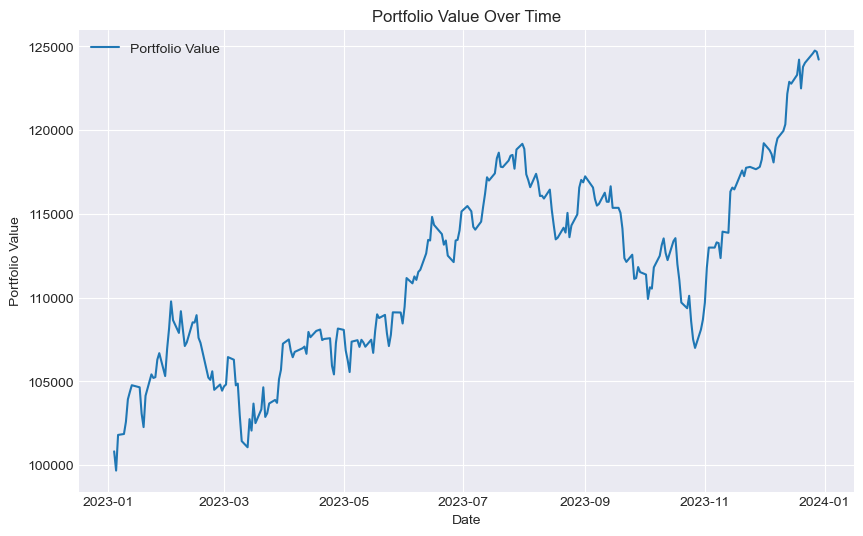

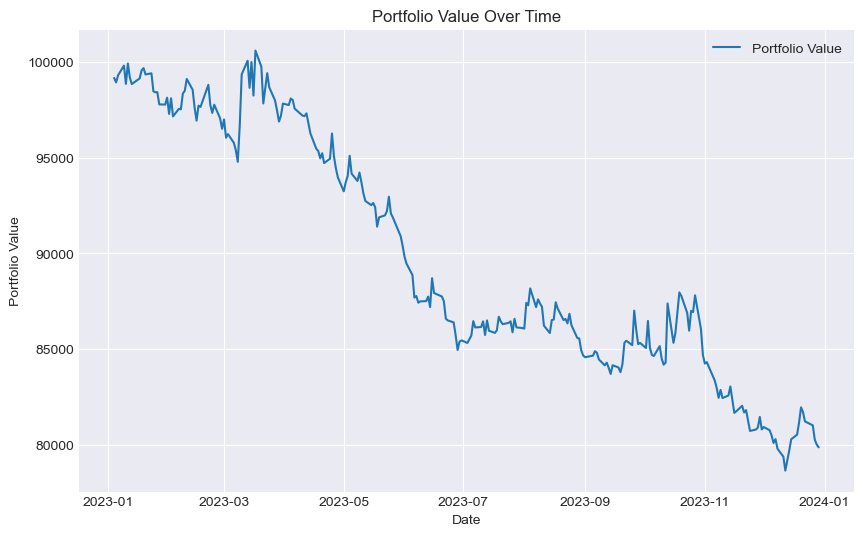

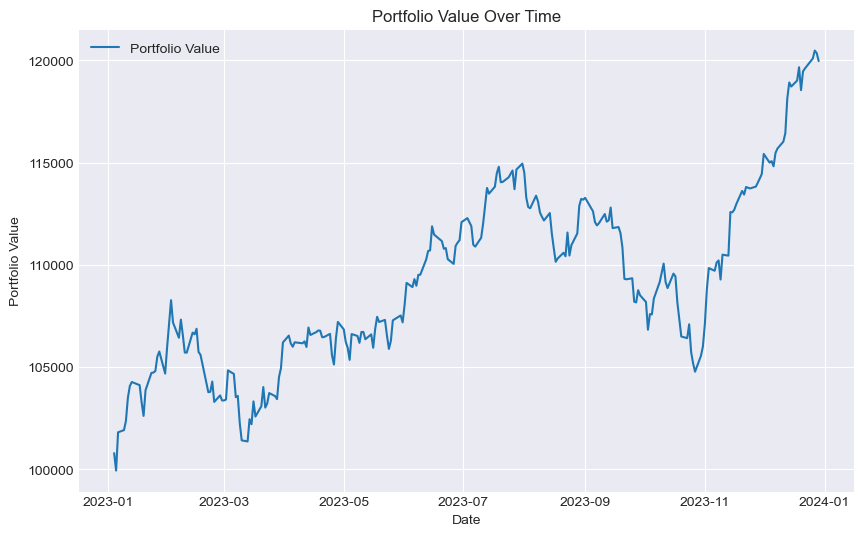

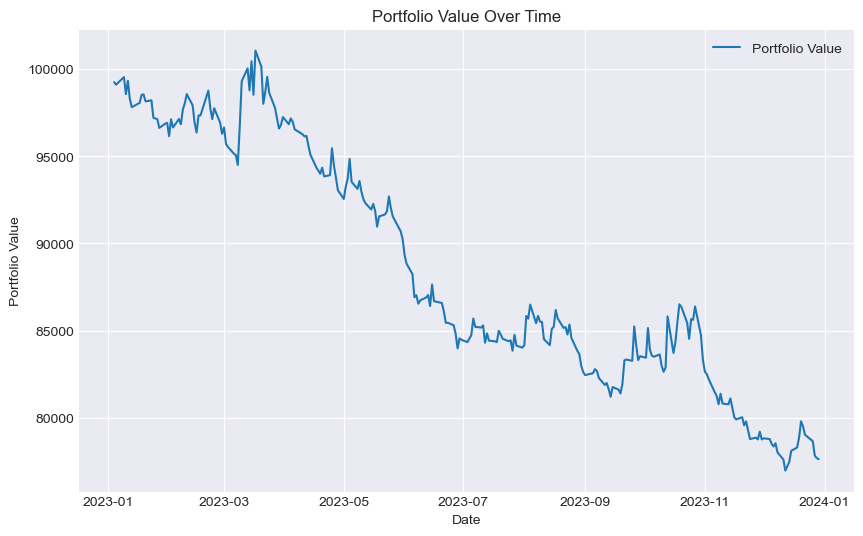

GA Model Metrics:
Weights: [0.10062446 0.11793073 0.27415584 0.26556212], Shares: {'AGG': 109, 'DBC': 514, 'VIXY': 483, 'VTI': 143}
{'Sharpe Ratio': -1.8316095472910776, 'Sortino Ratio': -3.4807849641808803, 'Max Drawdown': 0.23850932294603844}

RL Model Metrics:
Weights: [0.33933579 0.67644042 0.46785681 0.39200277], Shares: {'AGG': 370, 'DBC': 2949, 'VIXY': 825, 'VTI': 211}
{'Sharpe Ratio': 0.202698737831462, 'Sortino Ratio': 0.3779117217927844, 'Max Drawdown': 0.5645249626232282}

LSTM Portfolio Metrics:
Weights:[0.00605825 0.00506754 0.0125159  0.9763583 ], Shares:{'AGG': 6, 'DBC': 22, 'VIXY': 22, 'VTI': 526}
{'Sharpe Ratio': 1.7304432962937053, 'Sortino Ratio': 2.9176762200877167, 'Max Drawdown': 0.10220232865689256}

Equal-Weighted Portfolio Metrics:
Weights:[0.25 0.25 0.25 0.25], Shares:{'AGG': 272, 'DBC': 1090, 'VIXY': 441, 'VTI': 134}
{'Sharpe Ratio': -1.6968175453111591, 'Sortino Ratio': -3.1654858774196053, 'Max Drawdown': 0.21804208534346126}

Mean-Variance Optimized Portfo

In [88]:
# Step 1: Data Preparation for Training and Testing
train_data = get_data(TICKERS, START_DATE, END_DATE)
normalized_train_data, _ = preprocess_data(train_data)

testing_data = get_data(TICKERS, '2023-01-01', '2024-01-01')
normalized_testing_data, testing_returns = preprocess_data(testing_data)

# Step 2: Train and Rebalance Portfolio in Training Phase (rebalancing every two years)
training_portfolio = Portfolio(100000, normalized_train_data)
model = Model()
initial_prices = testing_data.loc[testing_data.index[0]]  # First row of the actual price data
# Rebalance every 2 years (252 trading days * 2)
final_allocations = train_and_rebalance_portfolio(training_portfolio, frequency=30, model=model)

# Step 3: Initialize Testing Portfolio with Final LSTM Weights
testing_portfolio = Portfolio(100000, normalized_testing_data)
testing_portfolio.rebalance(final_allocations)
LSTM_shares = testing_portfolio.calculate_initial_shares(100000,initial_prices)  # Calculate initial shares based on final allocations
testing_portfolio.calculate_daily_returns()     # Track performance in testing period
testing_portfolio.plot_portfolio_value()        # Visualize portfolio value over time
# Step 4: Calculate Performance Metrics for LSTM Portfolio
metrics = calculate_metrics(testing_portfolio.portfolio_history)

# Step 5: Baseline Strategies Setup and Evaluation
# Equal-Weighted and Mean-Variance Optimized Portfolios
equal_weights = equal_weighted_strategy(testing_returns)
mv_optimized_weights = mean_variance_optimized_strategy(testing_returns)

equal_weight_portfolio = Portfolio(100000, normalized_testing_data)
mv_optimized_portfolio = Portfolio(100000, normalized_testing_data)

equal_weight_portfolio.rebalance(equal_weights)
mv_optimized_portfolio.rebalance(mv_optimized_weights)

equal_weight_portfolio.calculate_daily_returns()
mv_optimized_portfolio.calculate_daily_returns()
ew_shares = equal_weight_portfolio.calculate_initial_shares(100000,initial_prices)
mv_shares = mv_optimized_portfolio.calculate_initial_shares(100000,initial_prices)
equal_weight_portfolio.plot_portfolio_value()
mv_optimized_portfolio.plot_portfolio_value()
# Step 6: Calculate Performance Metrics for Baseline Portfolios
equal_weight_metrics = calculate_metrics(equal_weight_portfolio.portfolio_history)
mv_optimized_metrics = calculate_metrics(mv_optimized_portfolio.portfolio_history)

# For RL Model Allocations
final_state = rl_portfolio.assets.iloc[-1].values
final_state = np.reshape(final_state, (1, -1))
rl_allocations = rl_agent.get_allocations(final_state)
rl_portfolio.rebalance(rl_allocations)
rl_shares = rl_portfolio.calculate_initial_shares(100000, initial_prices)
rl_portfolio.calculate_daily_returns()
rl_metrics = calculate_metrics(rl_portfolio.portfolio_history)

# For GA Allocations
ga_shares = testing_portfolio_ga.calculate_initial_shares(100000, initial_prices)
testing_portfolio_ga.calculate_daily_returns()
testing_portfolio_ga.plot_portfolio_value()
ga_metrics = calculate_metrics(testing_portfolio_ga.portfolio_history)

print("GA Model Metrics:")
print(f"Weights: {ga_allocations}, Shares: {ga_shares}")
print(ga_metrics)

print("\nRL Model Metrics:")
print(f"Weights: {rl_allocations}, Shares: {rl_shares}")
print(rl_metrics)

print("\nLSTM Portfolio Metrics:")
print(f"Weights:{final_allocations}, Shares:{LSTM_shares}")
print(metrics)

print("\nEqual-Weighted Portfolio Metrics:")
print(f"Weights:{equal_weights}, Shares:{ew_shares}")
print(equal_weight_metrics)

print("\nMean-Variance Optimized Portfolio Metrics:")
print(f"Weights:{mv_optimized_weights}, Shares:{mv_shares}")
print(mv_optimized_metrics)


Epoch 1/20


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: -0.0653
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1259
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.2006
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.2926
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.4046
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.5362
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.6773
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.8034
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.8835
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.9086
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.9009
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.8849
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.8721
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.8657
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.8659
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━

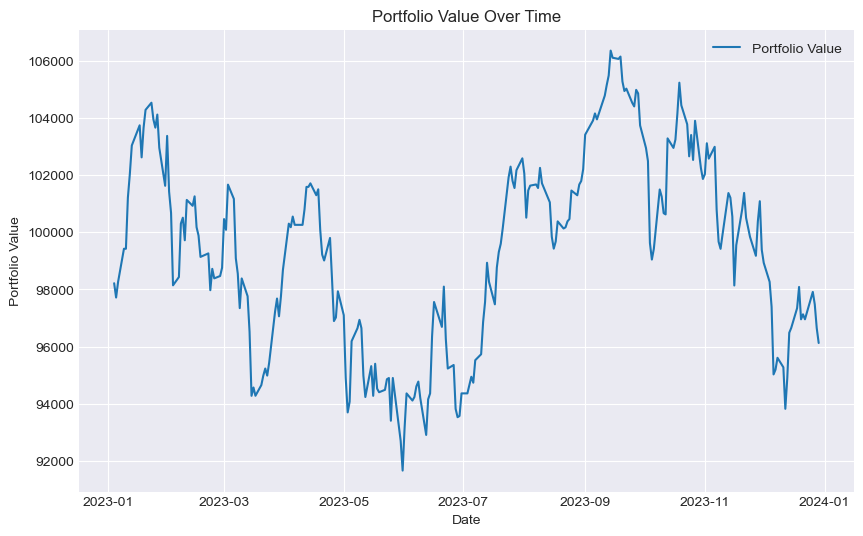

LSTM Portfolio Metrics:
Weights:[6.3326891e-04 9.9732333e-01 2.9449165e-04 1.7488451e-03], Shares:{'AGG': 0, 'DBC': 4348, 'VIXY': 0, 'VTI': 0}
{'Sharpe Ratio': -0.06271251154602486, 'Sortino Ratio': -0.0966672557847853, 'Max Drawdown': 0.12295797627241428}
Epoch 1/20


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step - loss: -0.2007
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2382
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: -0.2817
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.3321
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: -0.3897
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.4536
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.5198
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.5776
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.6090
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.6096
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.6041
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.6115
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.6345
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.6678
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.7019
Epoch 16/20
1/1 ━━━━━━━━━━━━━

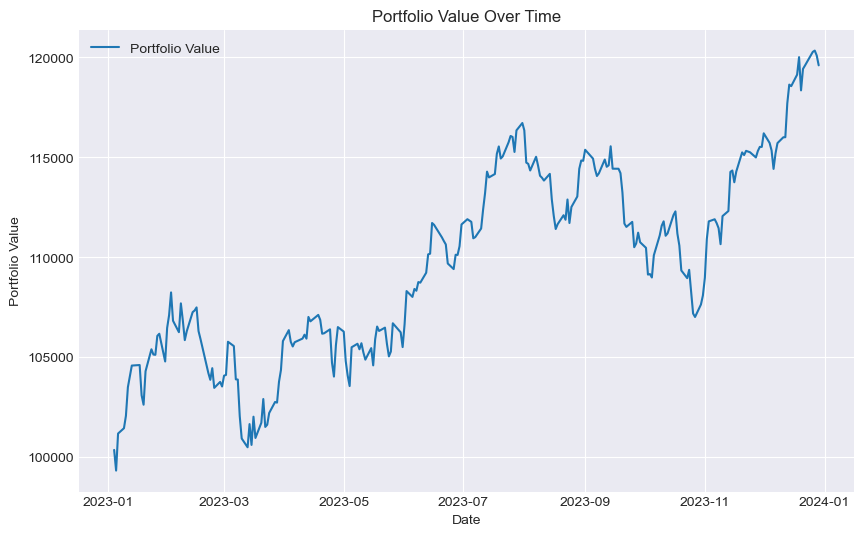

LSTM Portfolio Metrics:
Weights:[0.00545376 0.1913554  0.00401526 0.79917556], Shares:{'AGG': 5, 'DBC': 834, 'VIXY': 7, 'VTI': 430}
{'Sharpe Ratio': 1.5672957137131094, 'Sortino Ratio': 2.6235998940182275, 'Max Drawdown': 0.08317608128541322}


In [56]:
#Comparison of performance with different training frequencies
model2 = Model()
training_portfolio = Portfolio(100000, normalized_train_data)
initial_prices = testing_data.loc[testing_data.index[0]]  # First row of the actual price data
# Rebalance every 2 years (252 trading days * 2)
final_allocations = train_and_rebalance_portfolio(training_portfolio, frequency=15, model=model2)

# Step 3: Initialize Testing Portfolio with Final LSTM Weights
testing_portfolio = Portfolio(100000, normalized_testing_data)
testing_portfolio.rebalance(final_allocations)
LSTM_shares = testing_portfolio.calculate_initial_shares(100000,initial_prices)  # Calculate initial shares based on final allocations
testing_portfolio.calculate_daily_returns()     # Track performance in testing period
testing_portfolio.plot_portfolio_value()        # Visualize portfolio value over time
# Step 4: Calculate Performance Metrics for LSTM Portfolio
metrics = calculate_metrics(testing_portfolio.portfolio_history)
print("LSTM Portfolio Metrics:")
print(f"Weights:{final_allocations}, Shares:{LSTM_shares}")
print(metrics)

model3 = Model()
training_portfolio = Portfolio(100000, normalized_train_data)
initial_prices = testing_data.loc[testing_data.index[0]]  # First row of the actual price data
# Rebalance every 2 years (252 trading days * 2)
final_allocations = train_and_rebalance_portfolio(training_portfolio, frequency=20, model=model3)

# Step 3: Initialize Testing Portfolio with Final LSTM Weights
testing_portfolio = Portfolio(100000, normalized_testing_data)
testing_portfolio.rebalance(final_allocations)
LSTM_shares = testing_portfolio.calculate_initial_shares(100000,initial_prices)  # Calculate initial shares based on final allocations
testing_portfolio.calculate_daily_returns()     # Track performance in testing period
testing_portfolio.plot_portfolio_value()        # Visualize portfolio value over time
# Step 4: Calculate Performance Metrics for LSTM Portfolio
metrics = calculate_metrics(testing_portfolio.portfolio_history)
print("LSTM Portfolio Metrics:")
print(f"Weights:{final_allocations}, Shares:{LSTM_shares}")
print(metrics)

## Testing clearly suggests a higher rebalancing frequency leads to better results, but with a greater risk of overfitting. I think opting for 15 days between rebalances would increase efficiency and reduce overfitting without sacrificing too much performance.
